<a href="https://colab.research.google.com/github/VVKate/Neural_University_HomeWorks/blob/main/13_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Домашнеее задание: Июльский курс (2020). Pro. Занятие 13
##Генерация текста
## Верхошинская Катерина Викторовна

## **LIGHT**

### **Задание 1**

Используя три любых простых вопроса, сравните ответы сети на них на разной степени
натренированности:

a) 20 эпох – удается ли боту отвечать целыми словами?

b) + 30 эпох на этой же сетке и с этими же вопросами – появился ли прогресс в качестве
ответа сети(ответ целыми предложениями разумной длины)?

c) Ещё + 50 эпох – удается ли сети выдавать ответы, “похожие на правду”?

In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

import logging
logging.disable(logging.WARNING)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/My Drive/Colab Notebooks/Базы/Диалоги(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[125]))

Количество пар вопрос-ответ : 11905
Пример диалога : ['Кто будете?', 'Колхозник.']


In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('я', 5), ('а', 6), ('ты', 7), ('это', 8), ('да', 9), ('в', 10), ('нет', 11), ('как', 12), ('и', 13), ('вы', 14), ('ну', 15), ('с', 16), ('на', 17), ('же', 18), ('так', 19), ('он', 20), ('у', 21), ('кто', 22), ('где', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('здесь', 30), ('еще', 31), ('почему', 32), ('о', 33), ('там', 34), ('тебе', 35), ('есть', 36), ('его', 37), ('за', 38), ('куда', 39), ('вот', 40), ('ничего', 41), ('вас', 42), ('знаю', 43), ('чем', 44), ('но', 45), ('она', 46), ('они', 47), ('ли', 48), ('чего', 49), ('вам', 50)]
Размер словаря : 15104


In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 170   18 5709    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 11)
Установленная длина вопросов на вход : 11


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Размеры раскодированного массива ответов на вход : (11900, 13)
Установленная длина ответов на вход : 13


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11900, 13, 15104)
Установленная длина вопросов на выход : 13


In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(11, )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(13, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c

decoderLSTM = LSTM(200, return_state=True, return_sequences=True)


decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 11, 200)      3020800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 13, 200)      3020800     input_2[0][0]                    
_______________________________________________________________________________________

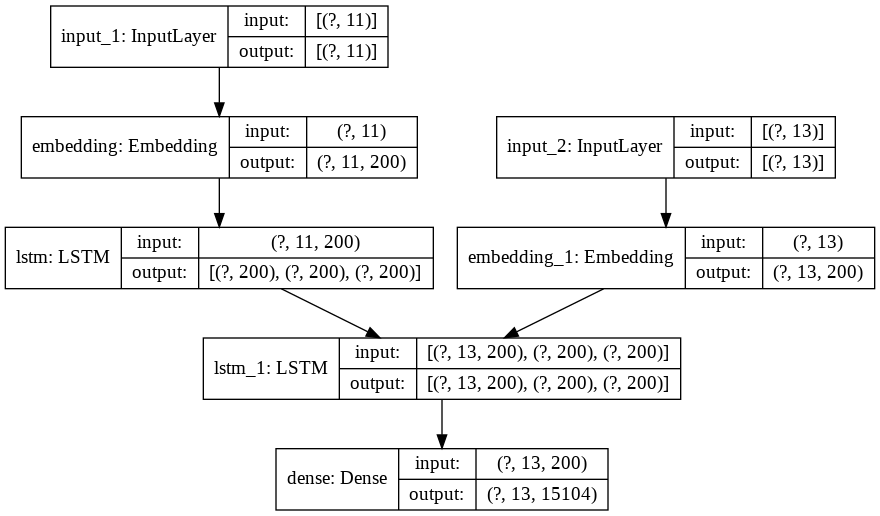

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png', show_shapes=True) # и построим график для визуализации слоев и связей между ними

#### **20 эпох**

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=20) 

Epoch 1/20
238/238 [==============================] - 10s 43ms/step - loss: 2.2199
Epoch 2/20
238/238 [==============================] - 10s 43ms/step - loss: 1.9760
Epoch 3/20
238/238 [==============================] - 10s 43ms/step - loss: 1.9270
Epoch 4/20
238/238 [==============================] - 10s 42ms/step - loss: 1.8871
Epoch 5/20
238/238 [==============================] - 10s 43ms/step - loss: 1.8510
Epoch 6/20
238/238 [==============================] - 10s 43ms/step - loss: 1.8171
Epoch 7/20
238/238 [==============================] - 10s 44ms/step - loss: 1.7849
Epoch 8/20
238/238 [==============================] - 10s 42ms/step - loss: 1.7528
Epoch 9/20
238/238 [==============================] - 10s 43ms/step - loss: 1.7188
Epoch 10/20
238/238 [==============================] - 10s 43ms/step - loss: 1.6853
Epoch 11/20
238/238 [==============================] - 10s 42ms/step - loss: 1.6515
Epoch 12/20
238/238 [==============================] - 10s 42ms/step - loss: 1.6161
E

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою

  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)

  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(3): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print("Ответ : ", decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : Как у тебя дела
Ответ :   да 
Задайте вопрос : Что делаешь
Ответ :   ничего 
Задайте вопрос : Почему
Ответ :   не знаю 


**Итоги:** пока бот совсем немногословен, но тем не мение на 2 и 3 вопросы, бот ответил вполне логично(сети удалось выдавать ответы, “похожие на правду”), почти как человек который не хочет общаться)))) 

#### **+ 30 эпох**

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=30) 

Epoch 1/30
238/238 [==============================] - 10s 43ms/step - loss: 1.3204
Epoch 2/30
238/238 [==============================] - 10s 42ms/step - loss: 1.2915
Epoch 3/30
238/238 [==============================] - 10s 42ms/step - loss: 1.2634
Epoch 4/30
238/238 [==============================] - 10s 42ms/step - loss: 1.2360
Epoch 5/30
238/238 [==============================] - 10s 42ms/step - loss: 1.2095
Epoch 6/30
238/238 [==============================] - 10s 43ms/step - loss: 1.1819
Epoch 7/30
238/238 [==============================] - 10s 42ms/step - loss: 1.1583
Epoch 8/30
238/238 [==============================] - 10s 42ms/step - loss: 1.1344
Epoch 9/30
238/238 [==============================] - 10s 42ms/step - loss: 1.1124
Epoch 10/30
238/238 [==============================] - 10s 42ms/step - loss: 1.0915
Epoch 11/30
238/238 [==============================] - 10s 42ms/step - loss: 1.0709
Epoch 12/30
238/238 [==============================] - 10s 42ms/step - loss: 1.0509
E

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(3): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print("Ответ : ", decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : Как у тебя дела
Ответ :   у меня на он был и один 
Задайте вопрос : Что делаешь
Ответ :   ничего 
Задайте вопрос : Почему
Ответ :   не знаю 


**Итоги:** появился небольшой прогресс в качестве ответа сети - ответ стал более длинным, целыми предложением(1 ответ), но пока это предложение с точки зрения логичнсти - полный бред - люди так не говорят.

#### **Еще + 50 эпох**

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50) 

Epoch 1/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7175
Epoch 2/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7165
Epoch 3/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7161
Epoch 4/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7163
Epoch 5/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7161
Epoch 6/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7156
Epoch 7/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7154
Epoch 8/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7150
Epoch 9/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7151
Epoch 10/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7148
Epoch 11/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7143
Epoch 12/50
238/238 [==============================] - 10s 43ms/step - loss: 0.7138
E

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(3): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print("Ответ : ", decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : Как у тебя дела
Ответ :   у меня на как он я так 
Задайте вопрос : Что делаешь
Ответ :   это я вы и что не да а что на вас ничего не 
Задайте вопрос : Почему
Ответ :   да так уж не знаю 


**Итоги:** сети так и не удалось выдать три ответа “похожих на правду”, но прогресс в удленении фразы заметен. Смысл пока только в третьем ответе улавливается. Вывод - сеть надо доучивать еще, сутя по прогрессу если продолжить обучение бот станет отвечать связанными предложениями, логически коректными и похожими на "человеческий" язык. 

### **Задание 2**


Попробуйте сделать любой небольшой набор диалогов(используем тот же формат
файла и способ хранения фраз: “ - - Вопрос” и “ - Ответ”) и использовать его на этой же
сетке. Проведите наблюдения:

а) Насколько быстрее обучается сетка

b) Способна ли она выдавать “адекватные” ответы

с) Ответы выглядят просто заученными под копирку или можно сказать, что генерируется
что-то новое?

In [ ]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/My Drive/Colab Notebooks/Базы/dialogs.yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[12]))

Количество пар вопрос-ответ : 271
Пример диалога : ['Какая погодка у вас сегодня?', 'жесть как холодно да еще и ветренно']


Для данного задания были собраны диалоги с 3 друзьми и коллегами (немногословными), и помещены в yml файл в формате "Вопрос" - "Ответ", получилось немного но бот научился общаться и на этой базе))) 

In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[2]))
print('Ответ : {}'.format(answers[2]))

Вопрос : Как дела?
Ответ : <START> Норм а ты как <END>


In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('на', 3), ('как', 4), ('ты', 5), ('сегодня', 6), ('в', 7), ('и', 8), ('у', 9), ('тебе', 10), ('что', 11), ('пойдем', 12), ('не', 13), ('вас', 14), ('кино', 15), ('о', 16), ('дела', 17), ('мне', 18), ('все', 19), ('вечер', 20), ('весело', 21), ('ага', 22), ('выходных', 23), ('еще', 24), ('чем', 25), ('надо', 26), ('какая', 27), ('погодка', 28), ('есть', 29), ('планы', 30), ('а', 31), ('норм', 32), ('то', 33), ('да', 34), ('я', 35), ('ок', 36), ('какое', 37), ('поедешь', 38), ('только', 39), ('сам', 40), ('конечно', 41), ('фильмец', 42), ('там', 43), ('за', 44), ('оно', 45), ('погода', 46), ('иди', 47), ('учиться', 48), ('погнали', 49), ('работа', 50)]
Размер словаря : 263


In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[41])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[41])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Погоняем на выходных?
Пример кодированного вопроса на вход : [84  3 23  0  0  0]
Размеры закодированного массива вопросов на вход : (271, 6)
Установленная длина вопросов на вход : 6


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[41])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[41][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> надо только резину сменить <END>
Пример раскодированного ответа на вход : [  1  26  39 229 230   2   0   0   0   0   0   0   0   0   0   0]
Размеры раскодированного массива ответов на вход : (271, 16)
Установленная длина ответов на вход : 16


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[16][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[16][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [  1 106 107 181  24   8  86   2   0   0   0   0   0   0   0   0]
Пример раскодированного ответа на выход : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (271, 16, 263)
Установленная длина вопросов на выход : 16


In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(6, )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(16, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c

decoderLSTM = LSTM(200, return_state=True, return_sequences=True)


decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 6, 200)       52600       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 16, 200)      52600       input_4[0][0]                    
_______________________________________________________________________________________

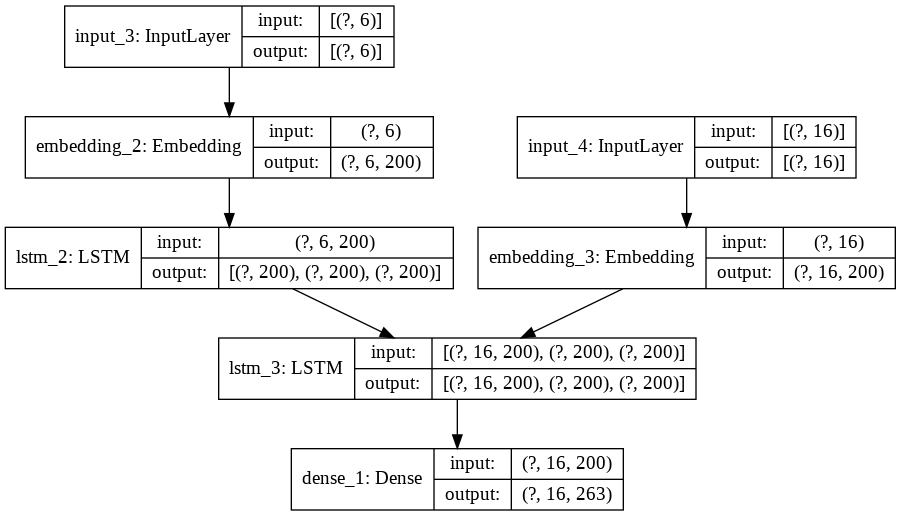

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png', show_shapes=True) # и построим график для визуализации слоев и связей между ними

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=200) 

Epoch 1/200
6/6 [==============================] - 0s 65ms/step - loss: 2.0592
Epoch 2/200
6/6 [==============================] - 0s 63ms/step - loss: 1.6530
Epoch 3/200
6/6 [==============================] - 0s 62ms/step - loss: 1.5416
Epoch 4/200
6/6 [==============================] - 0s 61ms/step - loss: 1.4844
Epoch 5/200
6/6 [==============================] - 0s 61ms/step - loss: 1.4338
Epoch 6/200
6/6 [==============================] - 0s 63ms/step - loss: 1.3660
Epoch 7/200
6/6 [==============================] - 0s 60ms/step - loss: 1.3120
Epoch 8/200
6/6 [==============================] - 0s 62ms/step - loss: 1.2522
Epoch 9/200
6/6 [==============================] - 0s 65ms/step - loss: 1.2293
Epoch 10/200
6/6 [==============================] - 0s 62ms/step - loss: 1.1432
Epoch 11/200
6/6 [==============================] - 0s 63ms/step - loss: 1.1124
Epoch 12/200
6/6 [==============================] - 0s 60ms/step - loss: 1.0325
Epoch 13/200
6/6 [==============================]

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою

  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)

  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

**Проведем небольшой диалог с ботом**

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(10): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print("Ответ:", decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : Привет
Ответ:  хаюшки 
Задайте вопрос : Как дела
Ответ:  норм как сам 
Задайте вопрос : хорошо есть планы на вечер
Ответ:  в универ надо 
Задайте вопрос : а на выходных
Ответ:  что за 
Задайте вопрос : Поедешь на выходных загород
Ответ:  погода дрянная сдеет еще оно мне надо 
Задайте вопрос : а в кино
Ответ:  а то 
Задайте вопрос : На какое кино пойдем
Ответ:  паразиты давай на них сходим они оскар выйграли как никак должен быть классный фильмец 
Задайте вопрос : а на Мстителей
Ответ:  только за 
Задайте вопрос : ок о чем думаешь
Ответ:  о том что завтра в командировку ехать 
Задайте вопрос : как там погода
Ответ:  потихоньку 


**Итоги:** На маленькой базе диалогов бот обучается быстро. Но есть факт заучивания. Бот отвечает фразами которые были в ответах не перефразируя их, единственное что можно отметить это то что задаваемых вопросов не было в диалоге (были похожие) но бот понял что на смысл и ответил почти как человек, той фразой что была на похожий вопрос. А части вопросов вообще не было. Чистая ипровизация бота - взять готовый ответ на другой вопрос и им ответить. Но ведь главное лочично все получилось, ну кроме последнего вопроса... Мои коллеги мне теперь парой ботов напоминают своими ответами)))) 

## **PRO**

### **Вариант 1**

**Задание:**
1.  Попробуйте улучшить текущий скрипт чат-бота, внедрив блок кода для присвоения
словам вне словаря(out-of-vocabulary) метки “unknown” так, чтобы встретив в запросе
незнакомое слово, исполнение кода не останавливалось, а продолжалось, игнорируя
“unknown” слова.
2. Текущая модель не учитывает знаки препинания в диалоге. Скорректируйте некоторые
блоки кода так, чтобы они учитывались. Проведите наблюдения, как добавление знаков
скажется на работе и результатах сетки.

In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

import logging
logging.disable(logging.WARNING)
import string

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/My Drive/Colab Notebooks/Базы/dialogs.yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[18]))

Количество пар вопрос-ответ : 268
Пример диалога : ['Есть планы на вечер ?', 'лучше не спрашивай , работы много']


In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[196]))
print('Ответ : {}'.format(answers[196]))

Вопрос : Пошли поедим
Ответ : <START> куда пойдем ? <END>


In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################
maxWordsCount = 200 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

tokenizer = Tokenizer(lower=True, split=' ', oov_token='unknown', char_level=False, filters='<>')
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('?', 4), (',', 5), ('на', 6), ('как', 7), ('сегодня', 8), ('ты', 9), ('в', 10), ('!', 11), ('тебе', 12), ('кино', 13), ('у', 14), ('пойдем', 15), ('дела', 16), ('что', 17), ('вас', 18), ('и', 19), ('о', 20), ('мне', 21), ('все', 22), ('весело', 23), ('не', 24), ('ага', 25), ('погодка', 26), ('еще', 27), ('норм', 28), ('вечер', 29), ('надо', 30), ('конечно', 31), ('какая', 32), ('выходных', 33), ('есть', 34), ('планы', 35), ('а', 36), ('сам', 37), ('там', 38), ('пошли', 39), ('да', 40), ('я', 41), ('ок', 42), ('какое', 43), ('только', 44), ('чем', 45), ('фильмец', 46), ('за', 47), ('то', 48), ('оно', 49), ('иди', 50)]
Размер словаря : 241


In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : О чем думаешь ?
Пример кодированного вопроса на вход : [20 45 61  4  0  0  0]
Размеры закодированного массива вопросов на вход : (268, 7)
Установленная длина вопросов на вход : 7


In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> О том что завтра в командировку ехать <END>
Пример раскодированного ответа на вход : [ 2 20 77 17 78 10 79 80  3  0  0  0  0  0  0  0  0  0  0  0  0]
Размеры раскодированного массива ответов на вход : (268, 21)
Установленная длина ответов на вход : 21


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [ 2 20 77 17 78 10 79 80  3  0  0  0  0  0  0  0  0  0  0  0  0]
Пример раскодированного ответа на выход : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (268, 21, 241)
Установленная длина вопросов на выход : 21


In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(7, )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(21, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c

decoderLSTM = LSTM(200, return_state=True, return_sequences=True)


decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_113"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 7, 200)       48200       input_59[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 21, 200)      48200       input_60[0][0]                   
_____________________________________________________________________________________

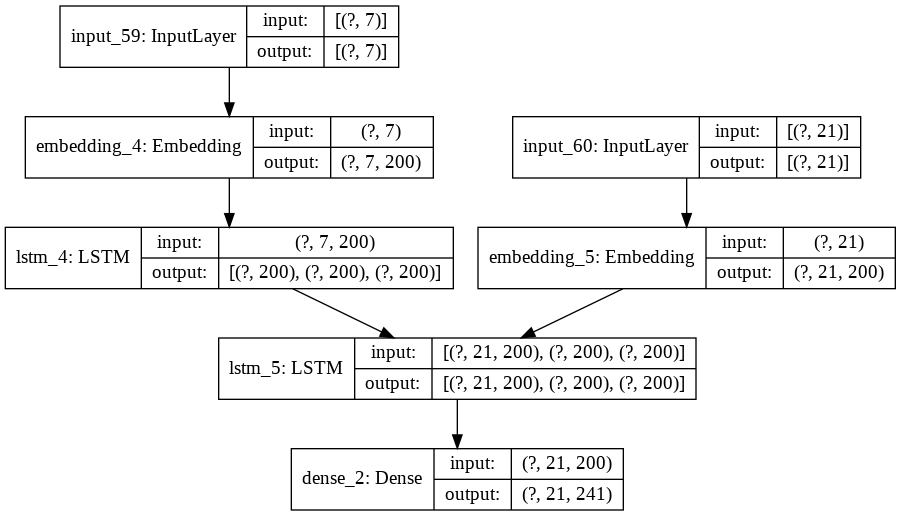

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png', show_shapes=True) # и построим график для визуализации слоев и связей между ними

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=150) 

Epoch 1/150
6/6 [==============================] - 0s 9ms/step - loss: 1.6572
Epoch 2/150
6/6 [==============================] - 0s 10ms/step - loss: 1.3185
Epoch 3/150
6/6 [==============================] - 0s 10ms/step - loss: 1.2382
Epoch 4/150
6/6 [==============================] - 0s 9ms/step - loss: 1.1909
Epoch 5/150
6/6 [==============================] - 0s 9ms/step - loss: 1.1461
Epoch 6/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0983
Epoch 7/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0459
Epoch 8/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0062
Epoch 9/150
6/6 [==============================] - 0s 9ms/step - loss: 0.9524
Epoch 10/150
6/6 [==============================] - 0s 9ms/step - loss: 0.9180
Epoch 11/150
6/6 [==============================] - 0s 9ms/step - loss: 0.8594
Epoch 12/150
6/6 [==============================] - 0s 8ms/step - loss: 0.8189
Epoch 13/150
6/6 [==============================] - 0s 9ms/

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою

  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)

  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    try:
       tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список
    except KeyError:
       tokensList.append(tokenizer.word_index['unknown'])
    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

**Проведем небольшой диалог с ботом, обученным на своей базе вопросов - ответов из LIGHT задания и сравним прогресс**

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(10): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print("Ответ : ", decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : Привет бот!
Ответ :   здарово ! 
Задайте вопрос : Как дела ИИшные?
Ответ :   норм , как сам 
Задайте вопрос : Поедешь на выходных загород шашлыки жарить?
Ответ :   погода дрянная , сдует еще , оно мне надо 
Задайте вопрос : а в кино пойдешь?
Ответ :   агась , на че пойдем ? 
Задайте вопрос : На паразитов?
Ответ :   хз 
Задайте вопрос : а на Мстителей
Ответ :   давай, кино отличное ! 
Задайте вопрос : как самочувствие?
Ответ :   ок 
Задайте вопрос : Тогда на великах погнали?
Ответ :   только учеба и сон 
Задайте вопрос : а как же кино и поесть?
Ответ :   учиться , а ты 
Задайте вопрос : я есть хочу
Ответ :   да иди 


**Итоги:** после добавления возможности писать слова которых нет в словаре и знаки припинания, диалог приобрел более выразительный характер. Бот отвечает вопросом на вопрос и уже научиться привередничать в выборе фильма - чего в диалоге изначальном не было!! Точно помню что ответ на кино "Паразиты" был явно хороший, а боту кино не по нраву, плюс ко всему у него появилась своя линия поведения- он хочет учиться и мои предложения пойти поесть он отвергает - посылая есть в одиночестве. Использование слов которых небыло в изночальном диалоге не помешало боту - а даже наоборот "преукрасило" его речь, сделав её более человечной, а фразы не такими заученными. 